**This method does not use Data Augmentation**

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
!rm -rf '/content/cats_vs_dogs_small'
!rm -rf '/content/dogs_cats'

In [18]:
!unzip -qq '/content/drive/MyDrive/Colab_Notebooks/SECONDYEAR_TRIMESTER4_Module03_deep-learning-applications/DAY3_APPLICATION_OF_DEEP_LEARNING/dogs_cats.zip'

In [19]:
import os, shutil, pathlib

original_dir = pathlib.Path("dogs_cats/train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,dst=dir / fname)
  
make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [20]:
from keras import layers
from keras import models

train_dir="/content/cats_vs_dogs_small/train"
validation_dir="/content/cats_vs_dogs_small/validation"
test_dir = "/content/cats_vs_dogs_small/test"

In [21]:
from keras.applications import VGG16

**Just reuse the bottom convolutional base of VGG16 model as its more generic, top will be related to specific classes so not used**

In [22]:
conv_base = VGG16(weights='imagenet',include_top=False,input_shape=(150, 150, 3))

**Extracting features using the pretrained convolutional base**

In [23]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [24]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
    directory,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        #print(labels_batch.shape)
        i += 1
        #Note that because generators yield data indefinitely in a loop,you must break after every image has been seen once
        if i * batch_size >= sample_count:
            break
    return features, labels

In [25]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
1/1 [==============================] - 0s 25ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 20ms/step
Found 2000 images belonging to 2 classes.
1/1 [==============================] - 0s 39ms/step


**The extracted features are currently of shape (samples, 4, 4, 512). You’ll feed them to a densely connected classifier, so first you must flatten them to (samples, 8192)**

In [26]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

**Defining and Training the Densely connected classifier**

In [27]:
from keras import models
from keras import layers
from keras import optimizers
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
loss='binary_crossentropy',
metrics=['acc'])
history = model.fit(train_features, train_labels,
epochs=30,
batch_size=20,
validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 1s 8ms/step - loss: 0.5910 - acc: 0.6720 - val_loss: 0.4348 - val_acc: 0.8340
Epoch 2/30
100/100 [==============================] - 1s 5ms/step - loss: 0.4198 - acc: 0.8110 - val_loss: 0.3556 - val_acc: 0.8610
Epoch 3/30
100/100 [==============================] - 1s 6ms/step - loss: 0.3472 - acc: 0.8575 - val_loss: 0.3179 - val_acc: 0.8800
Epoch 4/30
100/100 [==============================] - 1s 6ms/step - loss: 0.3030 - acc: 0.8745 - val_loss: 0.2993 - val_acc: 0.8800
Epoch 5/30
100/100 [==============================] - 1s 5ms/step - loss: 0.2781 - acc: 0.8860 - val_loss: 0.2816 - val_acc: 0.8850
Epoch 6/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2626 - acc: 0.8985 - val_loss: 0.2721 - val_acc: 0.8890
Epoch 7/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2375 - acc: 0.9095 - val_loss: 0.2668 - val_acc: 0.8890
Epoch 8/30
100/100 [==============================] - 0s 4ms/step - loss: 0.

Plotting the results

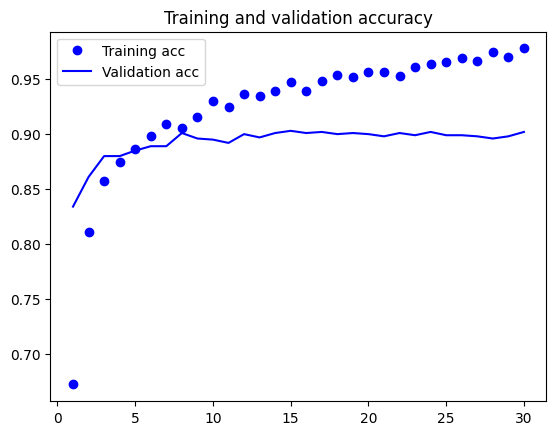

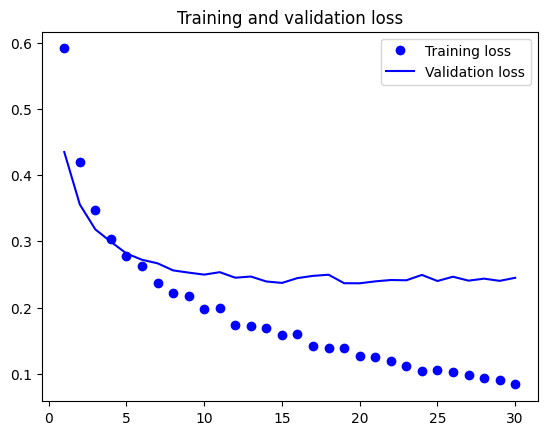

In [29]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [14]:
!jupyter nbconvert --to html Keras_cats_dogs_convnet_pretrained_features.ipynb

[NbConvertApp] Converting notebook Keras_cats_dogs_convnet_pretrained_features.ipynb to html
[NbConvertApp] Writing 680244 bytes to Keras_cats_dogs_convnet_pretrained_features.html
